In [1]:
%load_ext autoreload
%autoreload 2

import sys

import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from flax.core import FrozenDict
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

sys.path.append("..")

import models.exact_gplvm as exact_gplvm
from libs.plots import plotly_true_and_prediction_surface, plt_scatter

In [2]:
# Load dataset

from sklearn.datasets import load_digits

digits = load_digits()
X, y = digits.data, digits.target

In [3]:
# Inference settings
import jax
import optax

X = StandardScaler().fit_transform(X)

Z_init = PCA(n_components=2).fit_transform(X)
Z_init = StandardScaler().fit_transform(Z_init)


req = dict(
    n_iter=10000,
    data=dict(X=X),
    params={
        "log_tau_z": jnp.log(1.0),
        "log_sgm_z": jnp.log(2.0),
        "log_eps_z": jnp.log(1.0e-3),
        "Z": jnp.asarray(Z_init),
    },
    optimizers={
        "log_tau_z": None,
        "log_sgm_z": optax.chain(
            optax.clip_by_global_norm(max_norm=1.0),
            optax.adam(learning_rate=1.0e-3),
        ),
        "log_eps_z": optax.chain(
            optax.clip_by_global_norm(max_norm=1.0),
            optax.adam(learning_rate=1.0e-3),
        ),
        "Z": optax.adam(learning_rate=1.0e-3),
    },
)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


100%|███████████████████████████████████████████████████████████| 10000/10000 [42:55<00:00,  3.88it/s, loss=86587.766]


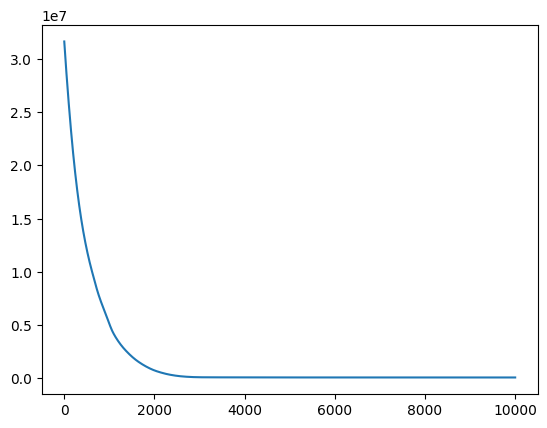

In [4]:
# Exec inference

res = exact_gplvm.inference(req)
plt.plot(res["loss_vals"])

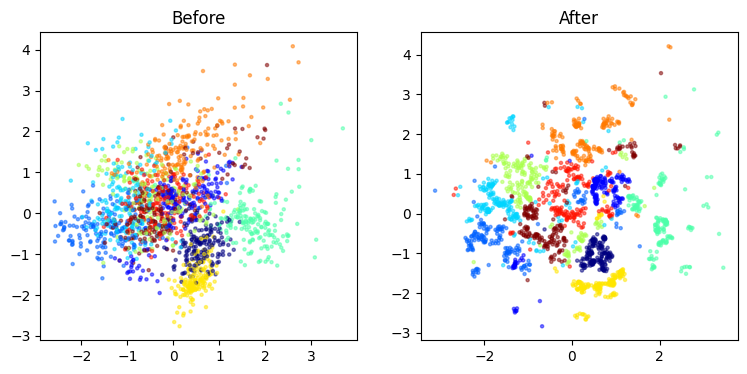

In [5]:
# Plot before / after

plt.figure(figsize=(9, 4))
plt.tight_layout()

plt.subplot(121)
plt.title("Before")
plt_scatter(Z_init, c=y, cmap="jet")

plt.subplot(122)
plt.title("After")
plt_scatter(res["params"]["Z"], c=y, cmap="jet")
# plt.colorbar()